In [1]:
!pip install mplfinance --root-user-action=ignore


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import mplfinance as mpf
import tensorflow as tf
from tensorflow import keras
from keras.layers import GRU, Dropout, SimpleRNN, LSTM, Dense, SimpleRNN, GRU
from keras.models import Sequential
color_pal = sns.color_palette()
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import joblib

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


2025-03-15 00:54:10.961640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742000050.984428    1645 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742000050.991394    1645 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742000051.010637    1645 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742000051.010667    1645 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742000051.010670    1645 computation_placer.cc:177] computation placer alr

In [91]:
df= pd.read_csv('/kaggle/input/d/theerfanyousefi/google-stock/HistoricalData_1741976057465.csv')
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,03/13/2025,$164.73,15206170,$167.98,$168.12,$164.07
1,03/12/2025,$169.00,19880060,$168.47,$169.53,$165.48
2,03/11/2025,$165.98,23705900,$166.68,$168.655,$163.24
3,03/10/2025,$167.81,28990720,$170.16,$170.45,$165.565
4,03/07/2025,$175.75,16395290,$173.242,$176.90,$172.25


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2515 non-null   object
 1   Close/Last  2515 non-null   object
 2   Volume      2515 non-null   int64 
 3   Open        2515 non-null   object
 4   High        2515 non-null   object
 5   Low         2515 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.0+ KB


In [72]:
df.describe()

,Volume
count,2.515000e+03
mean,3.027780e+07
std,1.517303e+07
min,6.809823e+06
25%,2.096274e+07
50%,2.660740e+07
75%,3.492820e+07
max,2.230700e+08


In [73]:
df.isnull().sum()

Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [92]:
df0=df.copy()

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

df = df.set_index('Date')

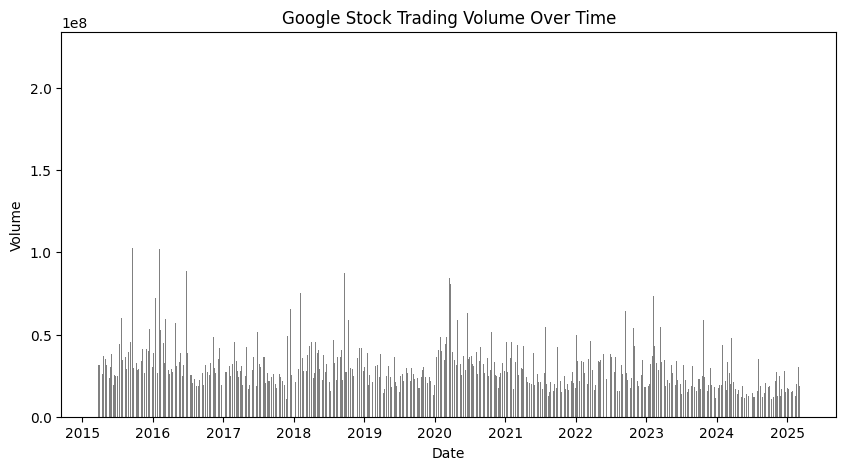

In [8]:
plt.figure(figsize=(10,5))
plt.bar(df.index, df['Volume'], color='gray')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Google Stock Trading Volume Over Time')
plt.show()


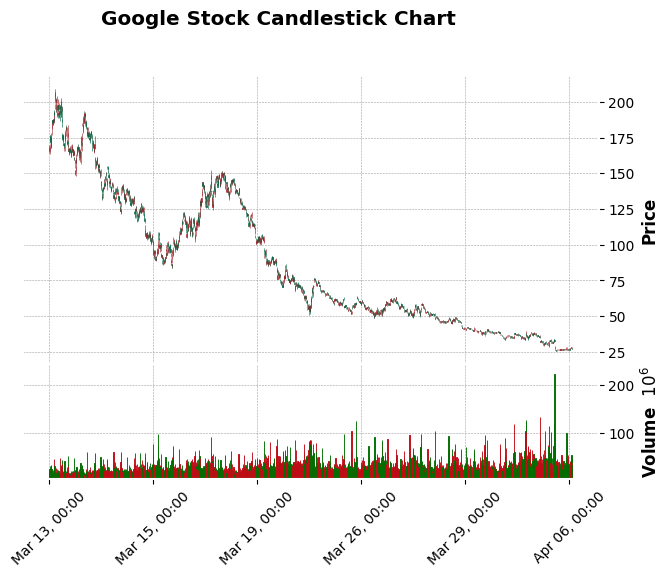

In [9]:

df['Close'] = df['Close/Last'].str.replace('$', '').astype(float)
df.drop(columns='Close/Last' ,inplace=True)
df['High'] = df['High'].str.replace('$', '').astype(float)
df['Low'] = df['Low'].str.replace('$', '').astype(float)
df['Open'] = df['Open'].str.replace('$', '').astype(float)

mpf.plot(df, type='candle', style='charles',volume=True , title='Google Stock Candlestick Chart')


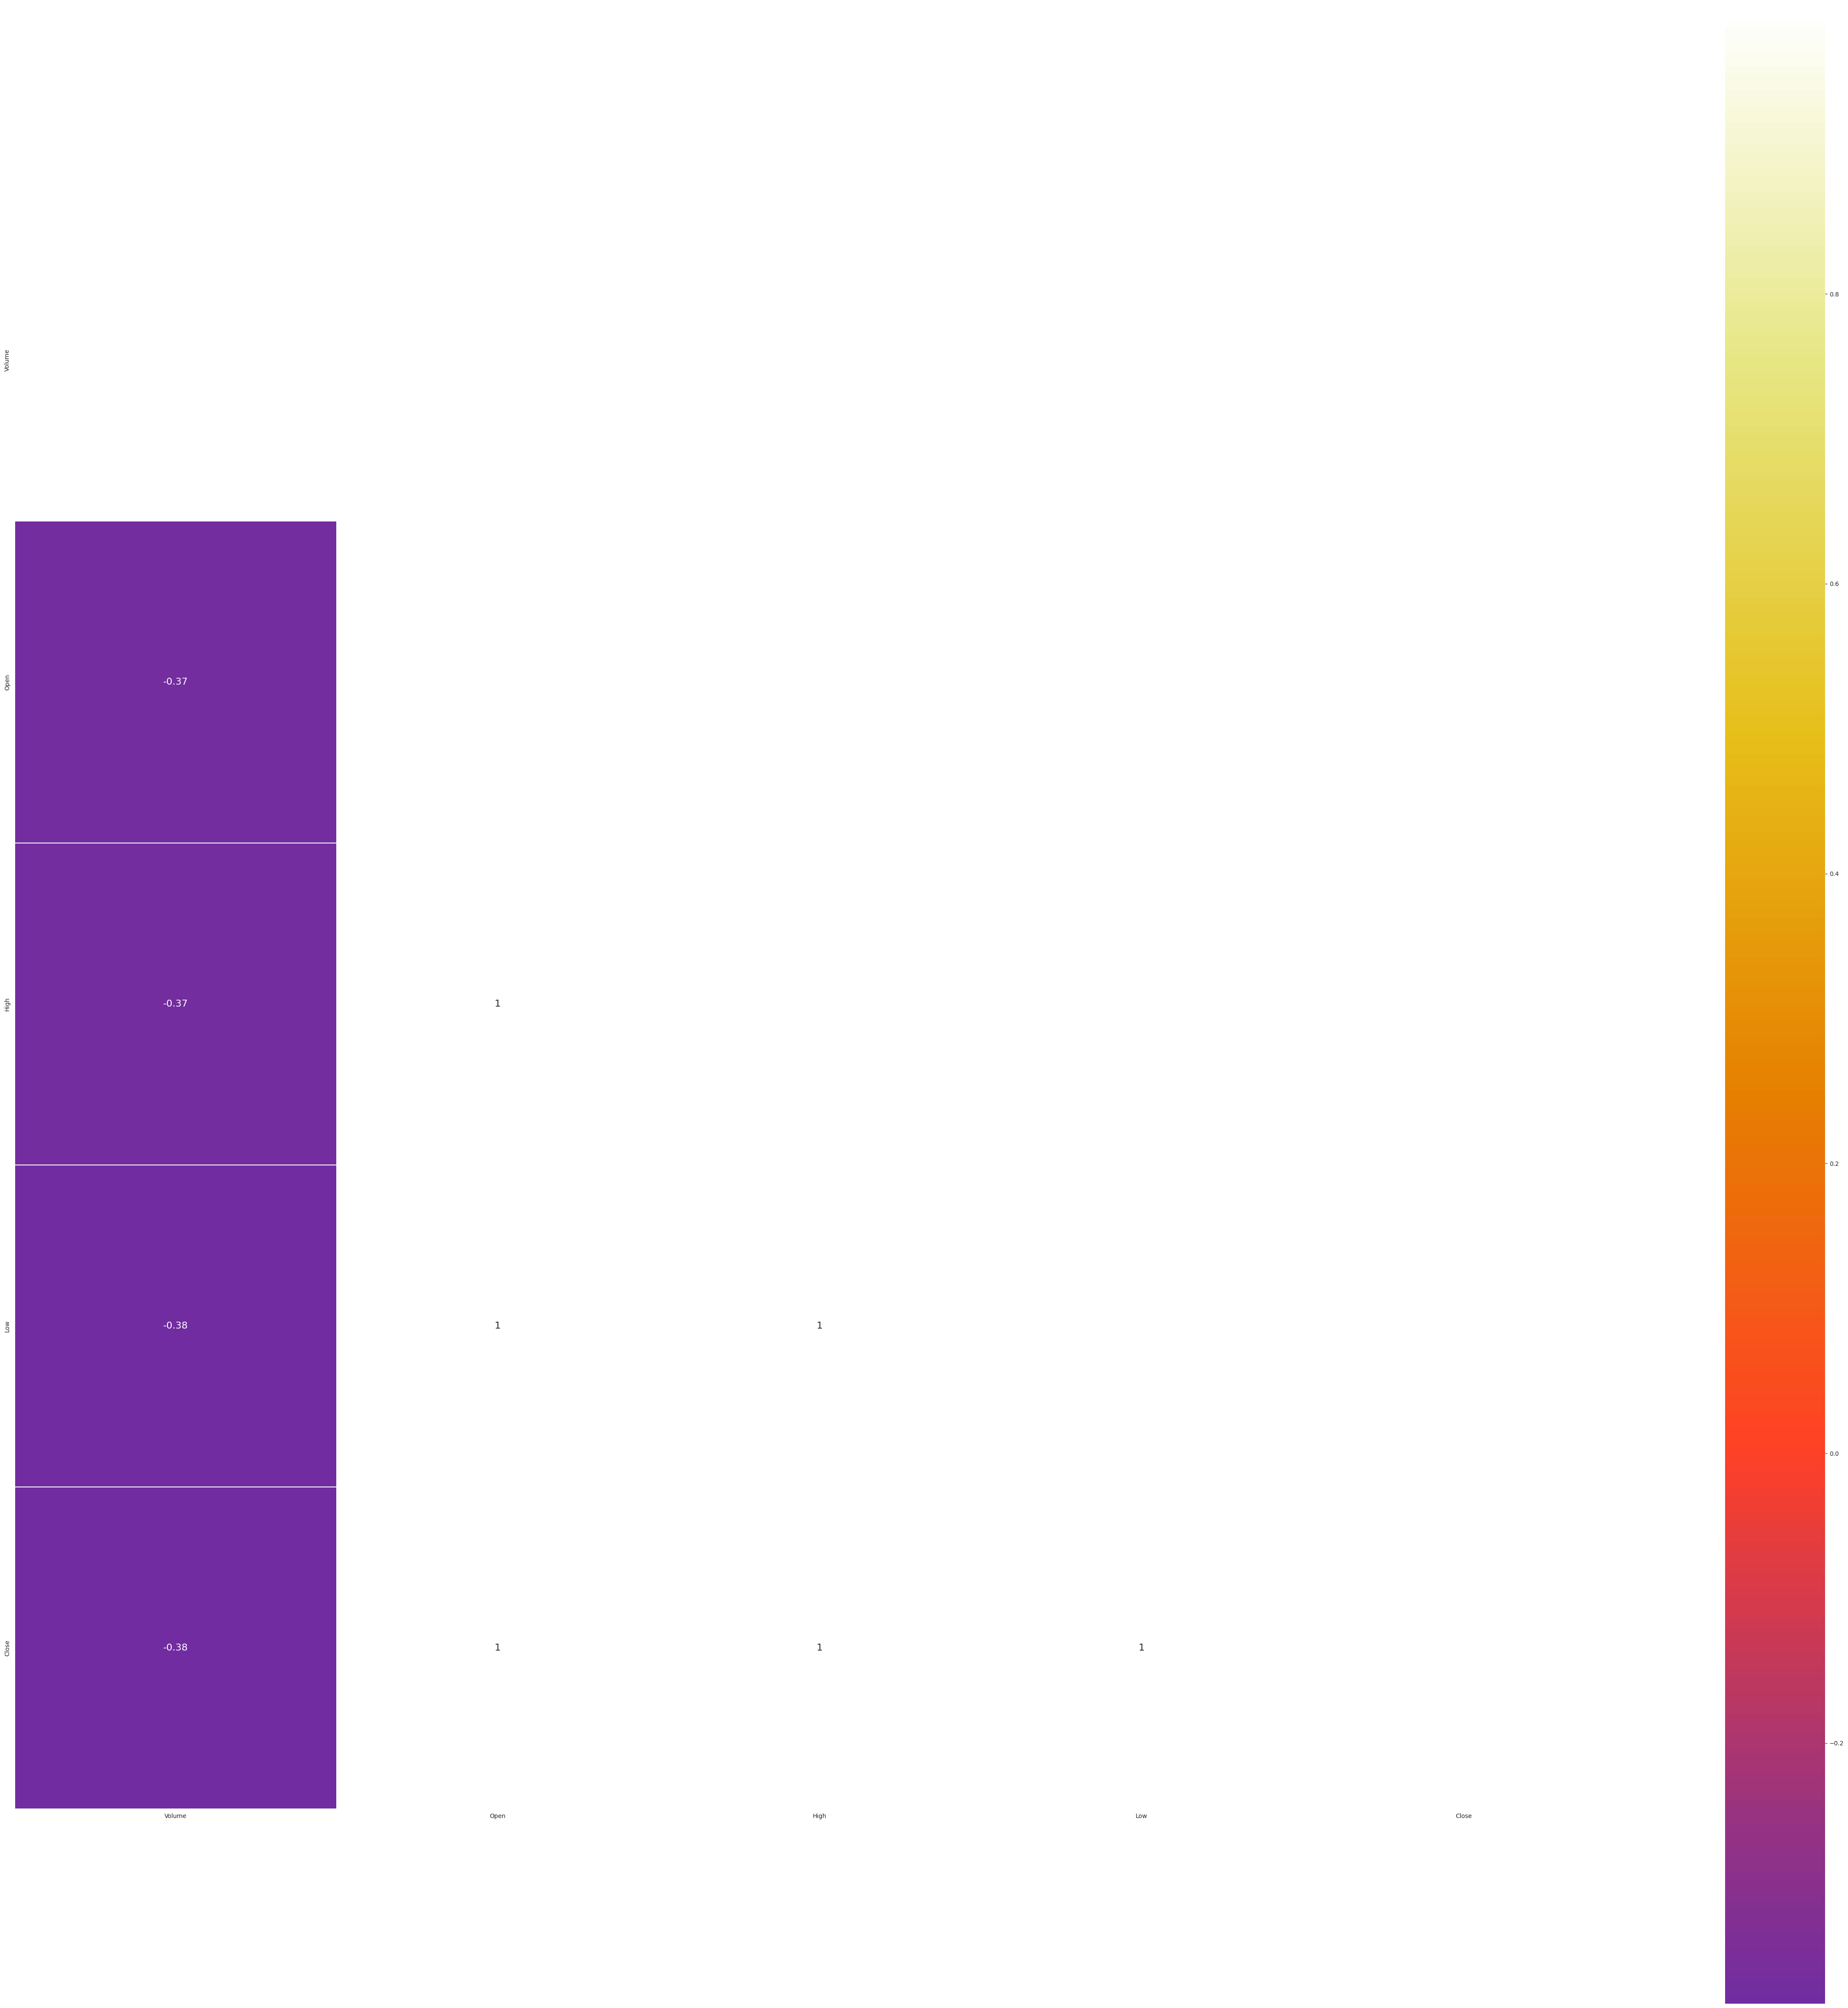

In [10]:
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(60,60))
    sns.heatmap(corr,  mask=mask, annot=True, cmap='CMRmap', center=0, linewidths=0.1, square=True,annot_kws={"size": 16})

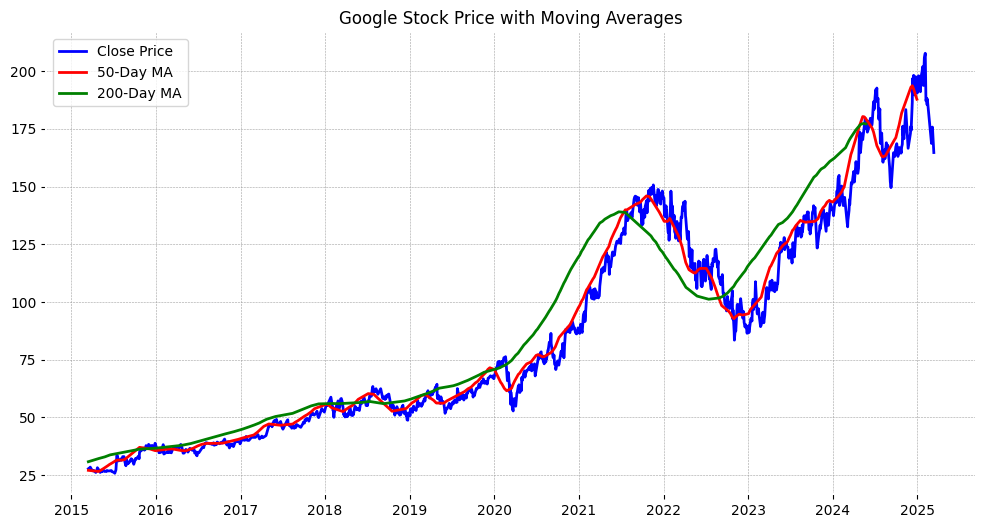

In [11]:
df['50_MA'] = df['Close'].rolling(window=50).mean()
df['200_MA'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['50_MA'], label='50-Day MA', color='red')
plt.plot(df.index, df['200_MA'], label='200-Day MA', color='green')
plt.legend()
plt.title('Google Stock Price with Moving Averages')
plt.show()


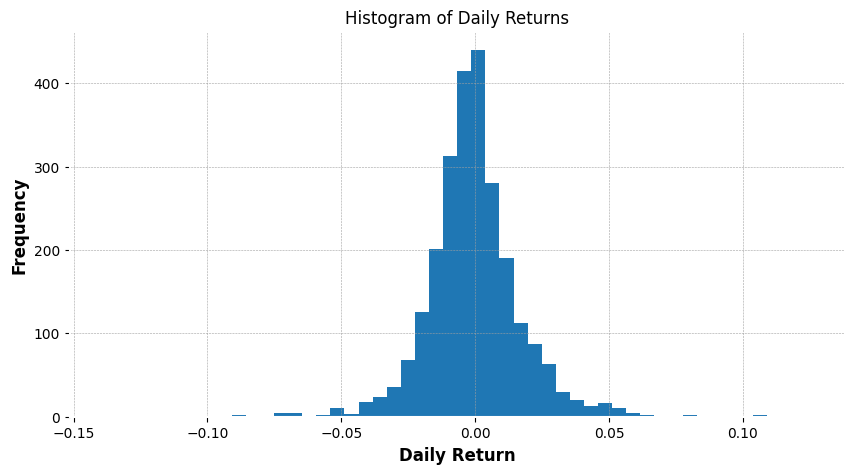

In [12]:
df['Daily_Return'] = df['Close'].pct_change()
df['Daily_Return'].hist(bins=50, figsize=(10, 5))
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()


In [13]:
df=df.drop(columns=['Open','Volume','High','Low','200_MA','50_MA','Daily_Return'])
df1=df.copy()
df1.head()

,Close
Date,
2025-03-13,164.73
2025-03-12,169.00
2025-03-11,165.98
2025-03-10,167.81
2025-03-07,175.75


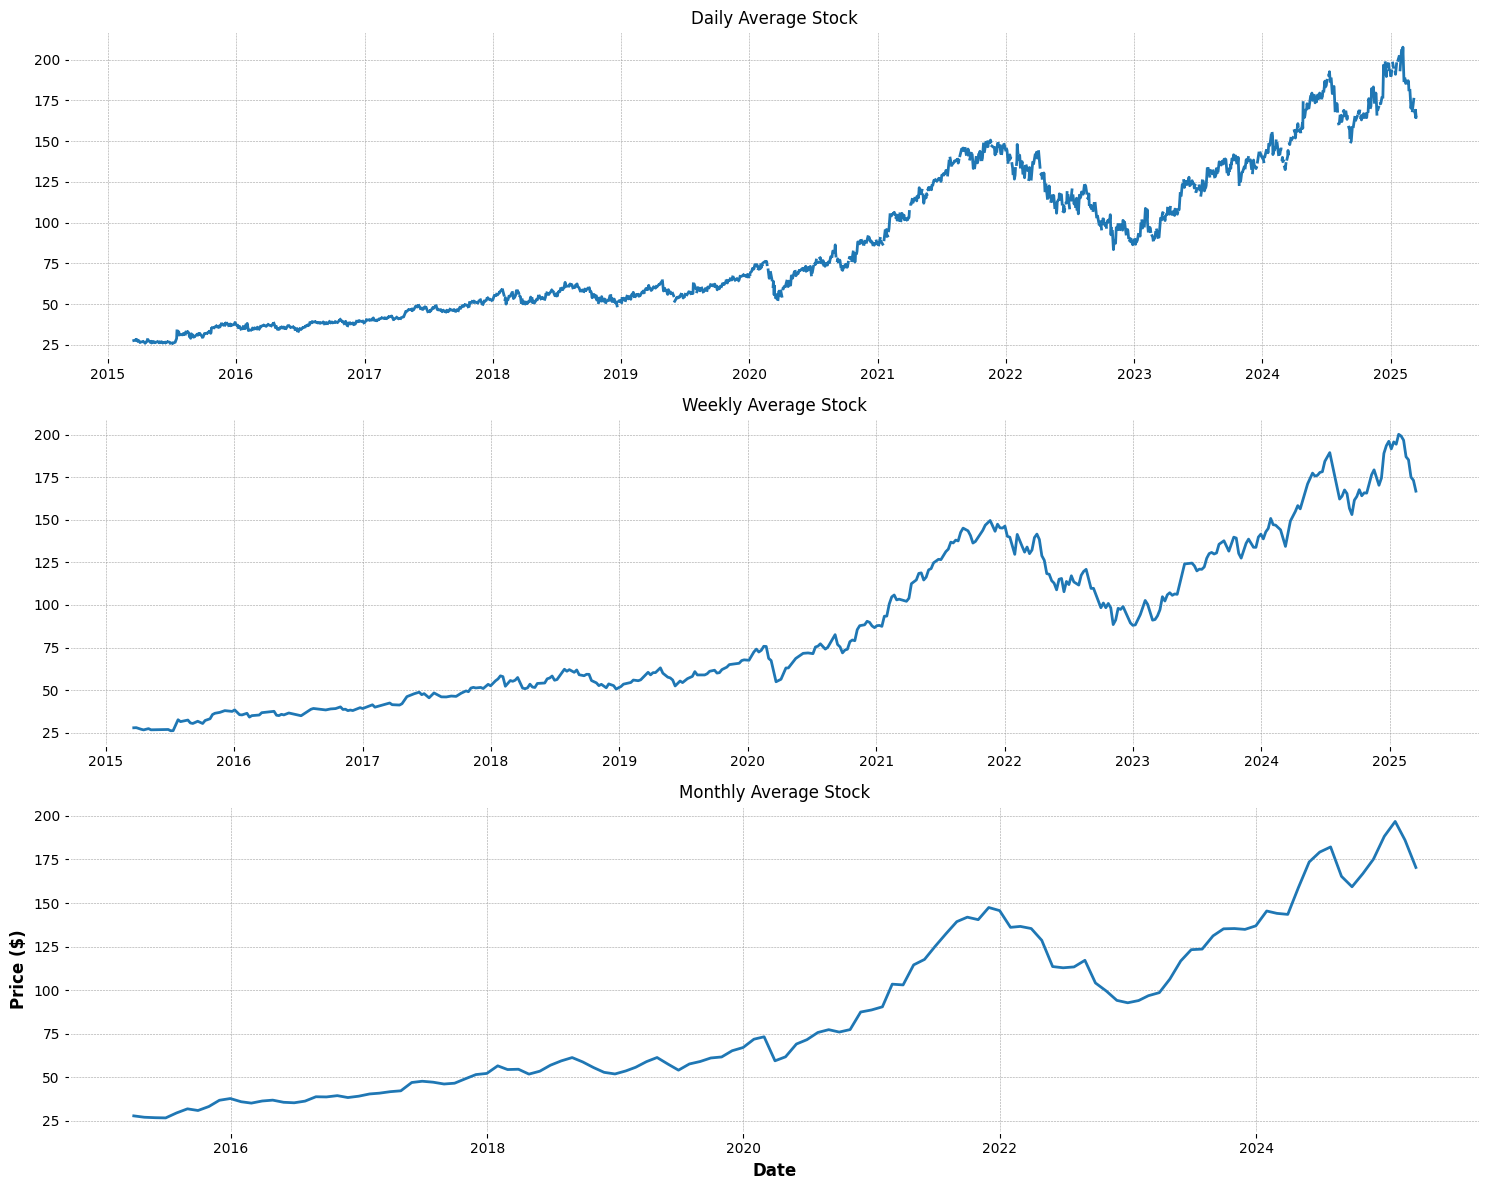

In [14]:
df_daily = df1.resample('D').mean()
df_weekly = df1.resample('W').mean()
df_monthly = df1.resample('M').mean()

# Plot resampled data
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
ax[0].plot(df_daily)
ax[0].set_title('Daily Average Stock')
ax[0].grid(True)

ax[1].plot(df_weekly)
ax[1].set_title('Weekly Average Stock')
ax[1].grid(True)

ax[2].plot(df_monthly)
ax[2].set_title('Monthly Average Stock')
ax[2].grid(True)

plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

In [15]:
df1 = df1[df1.index < pd.to_datetime("2024-01-01")]
df1

,Close
Date,
2023-12-29,140.9300
2023-12-28,141.2800
2023-12-27,141.4400
2023-12-26,142.8200
2023-12-22,142.7200
...,...
2015-03-20,28.0180
2015-03-19,27.8995
2015-03-18,27.9750


In [16]:
df1 = df1.reset_index(drop=True)

In [17]:
google_processed = df1.iloc[:,0:1].values
google_processed

array([[140.93  ],
       [141.28  ],
       [141.44  ],
       ...,
       [ 27.975 ],
       [ 27.542 ],
       [ 27.7255]])

In [18]:
scaler = MinMaxScaler(feature_range = (0, 1))

google_training_scaled = scaler.fit_transform(apple_processed)


In [19]:
features_set = []
labels = []
for i in range(60, google_training_scaled.shape[0]):
    features_set.append(google_training_scaled[i-60:i, 0])
    labels.append(google_training_scaled[i, 0])

In [20]:
features_set = np.array(features_set)
labels = np.array(labels)

In [21]:
print(google_training_scaled)
print(google_training_scaled.shape)

[[0.92168499]
 [0.92448796]
 [0.92576932]
 ...
 [0.01708611]
 [0.01361844]
 [0.01508799]]
(2215, 1)


In [22]:
features_set, labels = np.array(features_set), np.array(labels)

In [23]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
print(features_set.shape)

(2155, 60, 1)


In [24]:
!pip install --upgrade tensorflow keras --root-user-action=ignore



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [25]:
RNN_model  = Sequential()
RNN_model .add(SimpleRNN(128, return_sequences=True, input_shape= (features_set.shape[1], 1)))
RNN_model .add(SimpleRNN(64, return_sequences=False))
RNN_model .add(Dense(25))
RNN_model .add(Dense(1))

# Compile the model
RNN_model .compile(optimizer='adam', loss='mean_squared_error')

# Train the model
RNN_model .fit(features_set, labels, batch_size=1, epochs=1)
RNN_model 

2025-03-15 00:54:26.220641: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


2155/2155 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - loss: 0.0302


<Sequential name=sequential, built=True>

In [26]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(128, return_sequences=True, input_shape= (features_set.shape[1], 1)))
LSTM_model.add(LSTM(64, return_sequences=False))
LSTM_model.add(Dense(25))
LSTM_model.add(Dense(1))

# Compile the model
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
LSTM_model.fit(features_set, labels, batch_size=1, epochs=1)


2155/2155 ━━━━━━━━━━━━━━━━━━━━ 45s 20ms/step - loss: 0.0034


In [27]:
GRU_model = Sequential()
GRU_model.add(GRU(128, return_sequences=True, input_shape= (features_set.shape[1], 1)))
GRU_model.add(GRU(64, return_sequences=False))
GRU_model.add(Dense(25))
GRU_model.add(Dense(1))

# Compile the model
GRU_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
GRU_model.fit(features_set, labels, batch_size=1, epochs=1)


2155/2155 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - loss: 0.0025


In [93]:
df0['Date'] = pd.to_datetime(df0['Date'])
google_testing_complete  = df0[df0['Date'] >= pd.to_datetime("2024-01-01")]

google_testing_complete['Close'] = google_testing_complete['Close/Last'].str.replace('$', '').astype(float)
google_testing_complete.drop(columns='Close/Last' ,inplace=True)
df0['Close'] = df0['Close/Last'].str.replace('$', '').astype(float)
df0.drop(columns='Close/Last' ,inplace=True)

google_testing_complete2 = google_testing_complete.select_dtypes(exclude=['datetime'])
df0 = df0.select_dtypes(exclude=['datetime'])

google_testing_processed = google_testing_complete2.iloc[:, 0:1].values

google_total = pd.concat((df0['Close'], google_testing_complete2['Close']), axis=0)

test_inputs = google_total[len(google_total) - len(google_testing_complete2) - 60:].values
test_inputs


array([ 26.3345,  26.3415,  26.6665,  26.835 ,  27.0155,  26.959 ,
        26.6995,  26.6055,  26.989 ,  26.9895,  26.616 ,  27.0055,
        27.1255,  26.9635,  26.868 ,  26.615 ,  26.6925,  26.92  ,
        26.481 ,  26.452 ,  26.785 ,  26.911 ,  26.535 ,  26.211 ,
        26.54  ,  27.039 ,  26.895 ,  26.867 ,  27.454 ,  27.684 ,
        27.7685,  28.253 ,  27.35  ,  26.9683,  26.6985,  26.769 ,
        26.2025,  26.69  ,  26.6265,  26.5195,  26.9585,  27.0005,
        27.039 ,  27.0805,  26.851 ,  26.8383,  26.7765,  27.128 ,
        27.4   ,  27.6015,  27.417 ,  27.7585,  27.9393,  28.5095,
        27.9405,  28.018 ,  27.8995,  27.975 ,  27.542 ,  27.7255,
       164.73  , 169.    , 165.98  , 167.81  , 175.75  , 174.21  ,
       174.99  , 172.61  , 168.66  , 172.22  , 170.21  , 174.7   ,
       177.37  , 181.19  , 181.58  , 186.64  , 187.13  , 185.8   ,
       186.87  , 187.88  , 185.43  , 187.07  , 188.2   , 187.14  ,
       193.31  , 193.3   , 207.71  , 202.64  , 205.6   , 202.6

In [94]:
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

test_features = []
for i in range(60, len(test_inputs)):
    test_features.append(test_inputs[i-60:i, 0])
    
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
test_features.shape


(300, 60, 1)

In [95]:
print(test_features.shape)
print(google_testing_processed.shape)


(300, 60, 1)
(300, 1)


In [96]:
# Evaluate the model on the test set
## RNN
RNN_test_loss = RNN_model.evaluate(test_features, google_testing_processed)
print(f'RNN Test Loss: {RNN_test_loss}')

## LSTM
LSTM_test_loss = LSTM_model.evaluate(test_features, google_testing_processed)
print(f'LSTM Test Loss: {LSTM_test_loss}')

## GRU
GRU_test_loss = GRU_model.evaluate(test_features, google_testing_processed)
print(f'LSTM Test Loss: {GRU_test_loss}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 437560262262784.0000
RNN Test Loss: 448808446066688.0
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 437560295817216.0000
LSTM Test Loss: 448808479621120.0
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 437560262262784.0000
LSTM Test Loss: 448808446066688.0


In [97]:
# RNN
RNN_predictions = RNN_model.predict(test_features)
RNN_predictions = scaler.inverse_transform(RNN_predictions)

# LSTM
LSTM_predictions = LSTM_model.predict(test_features)
LSTM_predictions = scaler.inverse_transform(LSTM_predictions)

# GRU
GRU_predictions = GRU_model.predict(test_features)
GRU_predictions = scaler.inverse_transform(GRU_predictions)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [100]:
google_prediction = google_testing_complete['Date']
google_prediction = pd.DataFrame(google_prediction)
google_prediction['RNN_Open'] = RNN_predictions
google_prediction['LSTM_Open'] = LSTM_predictions
google_prediction['GRU_Open'] = GRU_predictions

google_prediction


,Date,RNN_Open,LSTM_Open,GRU_Open
0,2025-03-13,25.477650,27.367691,23.187313
1,2025-03-12,102.314438,54.340153,103.149567
2,2025-03-11,149.353897,89.662201,156.652145
3,2025-03-10,156.459000,118.789055,167.860550
4,2025-03-07,166.582825,138.606476,172.239014
...,...,...,...,...
295,2024-01-08,146.163681,140.527069,146.685455
296,2024-01-05,145.187927,139.742706,144.844025
297,2024-01-04,143.866470,138.304413,141.913742
298,2024-01-03,142.113831,137.160675,141.618973


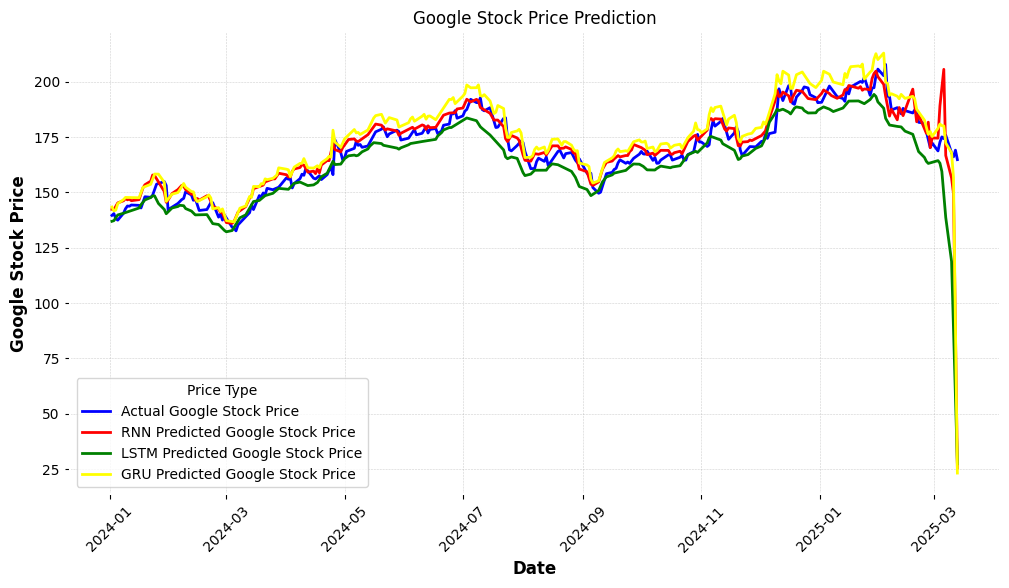

In [102]:
plt.figure(figsize=(12, 6))

# Plot actual Google stock price
plt.plot(google_testing_complete.Date, google_testing_complete.Close, 
         label='Actual Google Stock Price', color='blue')

# Plot RNN predicted stock price
plt.plot(google_prediction.Date, google_prediction.RNN_Open, 
         label='RNN Predicted Google Stock Price', color='red')

# Plot LSTM predicted stock price
plt.plot(google_prediction.Date, google_prediction.LSTM_Open, 
         label='LSTM Predicted Google Stock Price', color='green')

# Plot GRU predicted stock price
plt.plot(google_prediction.Date, google_prediction.GRU_Open, 
         label='GRU Predicted Google Stock Price', color='yellow')

# Set title and labels
plt.title('Google Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Google Stock Price')

# Add legend
plt.legend(title='Price Type')

# Improve x-axis readability
plt.xticks(rotation=45)

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()
